# 5. Generate predictions using a customisable hospital hierarchy. 

In previous notebooks I have shown the prediction of demand by specialty, using a hard-coded list of specialties (medical, surgical, haem/onc and pediatric).

In the real UCLH application, our users are interested in multiple levels of prdiction. For example, within the medical division, the Medical Director might want high level information about pressure on the division as a whole, while a ward manager would only want to know only about the pressures of their clinical area. 

This means generating predictions at a much more fine-grained level - for up to 50 reporting units and 250+ subspecialties, so a hard-coded list is unsuitable. 

This notebooks shows how we can set up our own hospital hierarchy. We can map these levels to the hospital's standard reporting groupings.

A typical workflow is:

1. Create or load a hierarchy structure:
   >>> hierarchy = Hierarchy.create_default_hospital()
   >>> # or load from YAML configuration
   >>> hierarchy = Hierarchy.from_yaml("config.yaml")

2. Populate the hierarchy with organizational data:
   >>> import pandas as pd
   >>> # The DataFrame must represent a proper tree structure where each child
   >>> # entity has exactly one parent. Each row represents one path through
   >>> # the hierarchy from bottom to top.
   >>> hierarchy_df = pd.DataFrame({
   ...     'specialty': ['Medical', 'Surgical', 'Haem/onc', 'Paediatric'],
   ...     'division': ['Medical Division', 'Surgical Division', 'Medical Division', 'Specialist Hospitals Division'],
   ... })


## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()


Inferred project root: /Users/zellaking/Repos/patientflow


## Create the hierarchy

Here I create a very simple hierarchy comprising only two levels. In the public dataset we only have four specialites available, so we'll pretend that these fall within three hospital divisions: medical, surgical and specialist. 

The first step is to create an entry in config.yaml specifying the names of each level and their relationship in the hierarchy. These names could be anything (eg 'specialty' could be 'clinical area' or 'firm'). It should look something like this: 

# Hierarchy configuration
# Defines the organizational hierarchy structure
levels:
  - entity_type: specialty
    parent_type: division
    level_order: 0
  - entity_type: division
    parent_type: null
    level_order: 1

In [ ]:
from patientflow.predict.hierarchy.structure import Hierarchy, populate_hierarchy_from_dataframe
import pandas as pd

# Read the yaml file to populate a hierarchy object
hierarchy = Hierarchy.from_yaml(project_root / "config.yaml")

# The hierarchy object has a `levels` attribute that shows the names of each level 
# and their relationship in the hierarchy.
print(hierarchy.levels)  

{EntityType('specialty'): HierarchyLevel(entity_type=EntityType('specialty'), parent_type=EntityType('division'), level_order=0), EntityType('division'): HierarchyLevel(entity_type=EntityType('division'), parent_type=None, level_order=1)}


Thus far, we only know the names of the levels (specialty, division), but not their contents. We can specify these in using a dataframe. The `column_mapping`parameter maps the column names in the dataframe to those specified in the hierarchy object. 

In [18]:
hierarchy_df = pd.DataFrame({
    'specialty_names': ['Medical', 'Surgical', 'Haem/onc', 'Paediatric'],
    'division_names': ['Medical Division', 'Surgical Division', 'Medical Division', 'Specialist Hospitals Division'],
})

column_mapping = {
    'specialty_names': 'specialty', # the column name in the dataframe that contains the specialty names
    'division_names': 'division', # the column name in the dataframe that contains the division names
}
populate_hierarchy_from_dataframe(
    hierarchy, hierarchy_df, column_mapping, top_level_id="Hospital"
)

print(hierarchy)

Hierarchy:
  specialty: 4
  division: 3


### Important note when creating hierarchies. 

The hierarchy must form a tree structure where each child entity can only have one parent. If the same child appears with different parents in different rows, the last relationship processed will overwrite previous ones, silently creating an invalid hierarchy. 

For example, this would be INVALID: 

Row 1: subspecialty='Cardiology', reporting_unit='Unit X', division='Division A' followed by Row 2: subspecialty='Cardiology', reporting_unit='Unit X', division='Division B'. 

This would result in 'Unit X' being assigned only to 'Division B' (the last one processed), overwriting the relationship to 'Division A', which violates the tree structure requirement and should be avoided. Note: Only entity types with a column_mapping entry will have entities created from the DataFrame, and the top_level_id ensures a single top-level entity exists (created if not in DataFrame, consolidated if present)


## Load data and prepare the models. 

I'm going to use real patient data from UCLH to demonstrate the implementation. I will follow the same method as in [notebook 4b](4b_Predict_emergency_demand.ipynb). Skip to the next cell. 

In [20]:
from patientflow.load import set_file_paths
import pandas as pd
from datetime import timedelta
from patientflow.load import load_data
from patientflow.load import load_config_file
from patientflow.prepare import create_temporal_splits
from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key
from patientflow.predictors.sequence_to_outcome_predictor import SequenceToOutcomePredictor
from patientflow.predictors.subgroup_predictor import MultiSubgroupPredictor
from patientflow.predictors.incoming_admission_predictors import ParametricIncomingAdmissionPredictor


# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
    project_root, 
    data_folder_name=data_folder_name,
    config_file = 'config.yaml', verbose=False)


# load ED snapshots data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date

# load data on inpatient arrivals
inpatient_arrivals = inpatient_arrivals = load_data(data_file_path, 
                    file_name='inpatient_arrivals.csv')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)

# set the training, validation and test sets
params = load_config_file(config_path)
start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

# create temporal splits
train_visits_df, valid_visits_df, test_visits_df = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

train_inpatient_arrivals_df, _, _ = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime",
)

# Train ED admissions model
grid = {"n_estimators": [30], "subsample": [0.7], "colsample_bytree": [0.7]} # simple grid for expediency

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

ordinal_mappings = {
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe\\E\\Very Severe",
    ],
    "latest_obs_level_of_consciousness": ["A", "C", "V", "P", "U"],
}

admissions_models = {}
model_name = 'admissions'

for prediction_time in ed_visits.prediction_time.unique():
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits_df,
        valid_visits=valid_visits_df,
        test_visits=test_visits_df,
        grid=grid,
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_key = get_model_key(model_name, prediction_time)
    
    admissions_models[model_key] = model

# Train specialty model
def create_subgroup_functions_from_age_group():
    """Create subgroup functions that work with age_group categorical variable."""
    
    def is_paediatric(row):
        return row.get("age_group") == "0-17"
    
    def is_adult(row):
        # All non-paediatric patients are adults
        return row.get("age_group") != "0-17"
    
    return {
        "paediatric": is_paediatric,
        "adult": is_adult,
    }

subgroup_functions = create_subgroup_functions_from_age_group()

spec_model = MultiSubgroupPredictor(
    subgroup_functions=subgroup_functions,
    base_predictor_class=SequenceToOutcomePredictor,
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    min_samples=50,  # Minimum samples required per subgroup
)
spec_model = spec_model.fit(train_visits_df)

# Train yet-to-arrive model
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = timedelta(minutes=params["prediction_window"])
yta_time_interval = timedelta(minutes=params["yta_time_interval"])

specialty_filters = filters={
    'medical': {'specialty': 'medical'},
    'surgical': {'specialty': 'surgical'},
    'haem/onc': {'specialty': 'haem/onc'},
    'paediatric': {'specialty': 'paediatric'}
    }

yta_model_by_spec =  ParametricIncomingAdmissionPredictor(filters = specialty_filters, verbose=False)

num_days = (start_validation_set - start_training_set).days

if 'arrival_datetime' in train_inpatient_arrivals_df.columns:
    train_inpatient_arrivals_df.set_index('arrival_datetime', inplace=True)

yta_model_by_spec =yta_model_by_spec.fit(train_inpatient_arrivals_df, 
              prediction_window=prediction_window, 
              yta_time_interval=yta_time_interval, 
              prediction_times=ed_visits.prediction_time.unique(), 
              num_days=num_days )

Split sizes: [62071, 10415, 29134]
Split sizes: [7716, 1285, 3898]
Training model for (22, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (12, 0)
Training model for (9, 30)


## Make predictions for via-ED flows using the hospital hierarchy. 

We now have models trained that we can use to create predicted probability distributions. To illustrate, I'll pick a random prediction date and time from the test set. 

In [11]:
from patientflow.viz.utils import format_prediction_time
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict

# Set seed
import numpy as np
np.random.seed(42)

# Randomly pick a prediction moment to do inference on
random_row = test_visits_df.sample(n=1)
random_prediction_time = random_row.prediction_time.values[0]
random_prediction_date = random_row.snapshot_date.values[0]

prediction_snapshots = ed_visits[(ed_visits.prediction_time == random_prediction_time) & \
            (ed_visits.snapshot_date == random_prediction_date)]

print(f'Number of adult patients in the ED at {format_prediction_time(random_prediction_time)} on {random_prediction_date}:',
      f'{len(prediction_snapshots[prediction_snapshots.age_group != "0-17"])}')

print(f'Number of patients under the age of 18 in the ED at {format_prediction_time(random_prediction_time)} on {random_prediction_date}:',
      f'{len(prediction_snapshots[prediction_snapshots.age_group == "0-17"])}')

# format patient snapshots for input into the admissions model
X_test, y_test = prepare_patient_snapshots(
    df=prediction_snapshots, 
    prediction_time=random_prediction_time, 
    single_snapshot_per_visit=False,
    exclude_columns=exclude_from_training_data, 
    visit_col='visit_number'
)

# retrieve the admissions model for the prediction time
admission_model = admissions_models[get_model_key(model_name, random_prediction_time)]

# prepare group snapshots dict to indicate which patients comprise the group we want to predict for
group_snapshots_dict = prepare_group_snapshot_dict(
    prediction_snapshots
    )

Number of adult patients in the ED at 22:00 on 2031-10-09: 69
Number of patients under the age of 18 in the ED at 22:00 on 2031-10-09: 10


The predicted bed counts for patients in the ED take three probabilities into account for each patient snapshots: 

* probability of being admitted after the ED has ended
* probability of being admitted to each specialty, if admitted
* probability of being admitted within the prediction window, taking into account how much time has elapsed since the patient arrived, and the stated ED targets

To set the ED targets, we use the parameters set in the config file. The config file also specifies the length of the prediction, and (for use later) the length of the discrete intervals used to calculate arrival rates for yet-to-arrive patients.

In [12]:
# set the ED targets
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
yta_time_interval = params["yta_time_interval"]

In the cell below I first calculate `prob_admission_in_window`, the probability of being admitted within the prediction window, given the elapsed time since each patient arrived, and the specified ED targets. 

Then, for each patient snapshot, I calculate 'prob_admission_to_specialty`, the probability of admission to specialty if admitted, by applying the specialty model trained earlier. 

These two probabilities for each patient snapshot are multiplied and the result passed to `get_prob_dist` function as weights. 

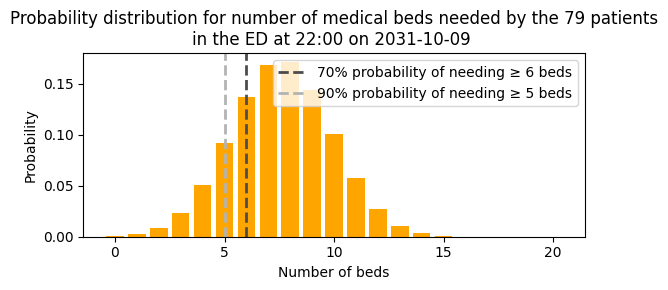

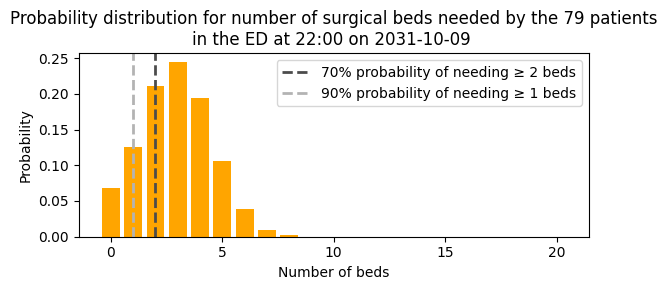

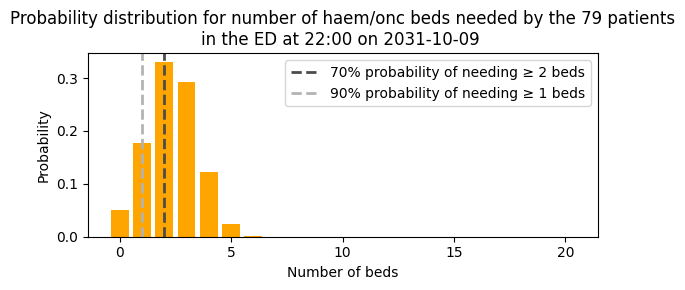

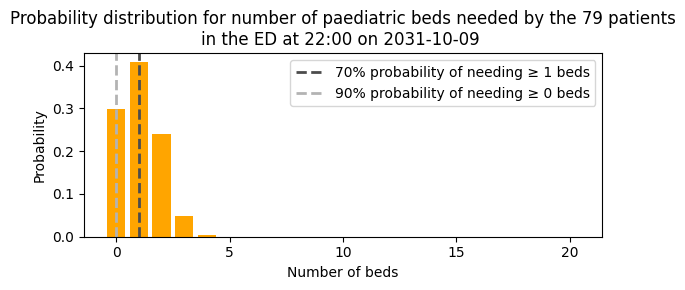

In [17]:
from patientflow.viz.probability_distribution import plot_prob_dist
from patientflow.aggregate import get_prob_dist
from patientflow.calculate.admission_in_prediction_window import calculate_probability
from datetime import timedelta

# Calculate probability of admission within prediction window using ED targets
prob_admission_in_window = prediction_snapshots.apply(
    lambda row: calculate_probability(
        elapsed_los = timedelta(seconds=row["elapsed_los"]), 
        prediction_window = timedelta(minutes=prediction_window),
        x1 = x1,
        y1 = y1,
        x2 = x2,
        y2 = y2
    ),
    axis=1,
)

# generate and plot predicted bed count distributions for each specialty
for specialty in ['medical', 'surgical', 'haem/onc', 'paediatric']:

# Use predict_dataframe for MultiSubgroupPredictor (handles subgroup routing automatically)
    if hasattr(spec_model, "predict_dataframe"):
        # Get specialty probabilities for all patients using predict_dataframe
        specialty_probs = spec_model.predict_dataframe(prediction_snapshots)
        # Extract probability for this specialty from the returned dictionaries
        prob_admission_to_specialty = specialty_probs.apply(
            lambda d: d.get(specialty, 0.0) if isinstance(d, dict) else 0.0
        )
    else:
        # Fallback for SequenceToOutcomePredictor (original behavior)
        prob_admission_to_specialty = prediction_snapshots['consultation_sequence'].apply(
            spec_model.predict
        ).apply(lambda x: x[specialty])    
        
    # get probability distribution weighted by probability of admission to specialty and probability of admission within prediction window
    prob_dist_dict = get_prob_dist(
            group_snapshots_dict, X_test, y_test, admission_model, 
            weights=prob_admission_to_specialty*prob_admission_in_window
        )

    title = (
        f'Probability distribution for number of {specialty} beds needed by the '
        f'{len(prediction_snapshots)} patients\n'
        f'in the ED at {format_prediction_time(random_prediction_time)} '
        f'on {random_prediction_date} '
    )
    plot_prob_dist(prob_dist_dict[random_prediction_date]['agg_predicted'], title, 
        include_titles=True, truncate_at_beds=20,
        probability_levels=[0.7,0.9],
        show_probability_thresholds=True, bar_colour='orange')

## Train model to predict bed count distributions for patients yet to arrive

As we are predicting by clinical area we will want the predicted bed counts for patients yet to arrive to be calculated for each separately. A dictionary, here called `specialty_filters`, is used to tell the `ParametricIncomingAdmissionPredictor` which column contains the outcome we want to split by. 

## Make predictions for patients yet-to-arrive to the ED who will need admission

The trained yet-to-arrive model generates the same distribution for each prediction time, irrespective of day of week, for each specialty. Passing the randomly chosen prediction time, for each specialty, will return the required distributions.


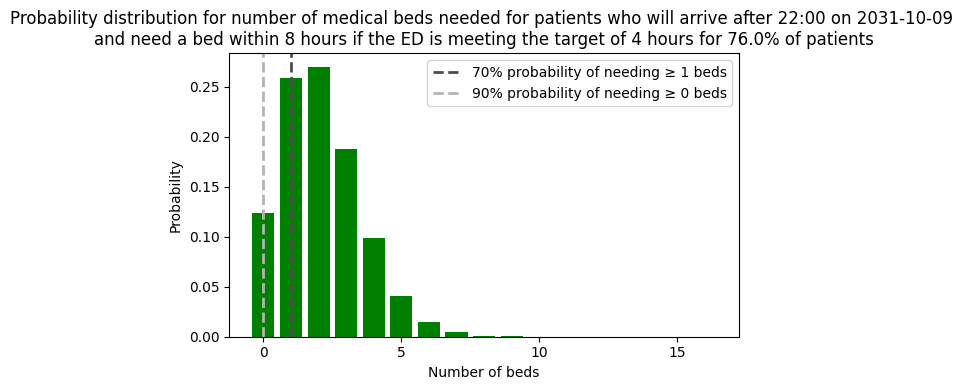

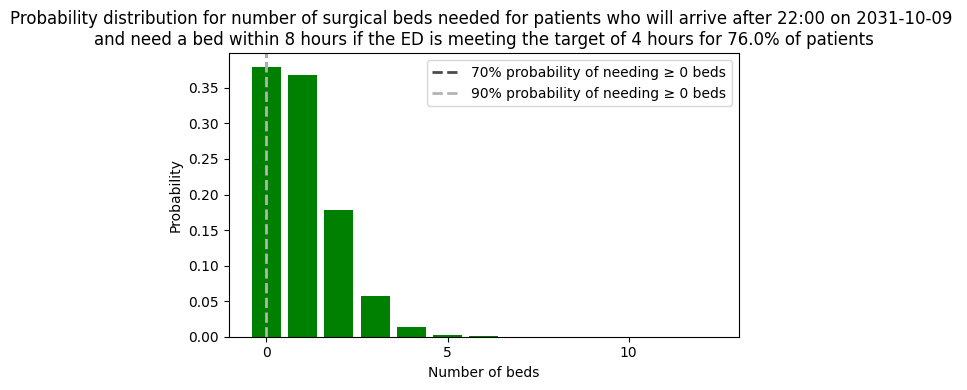

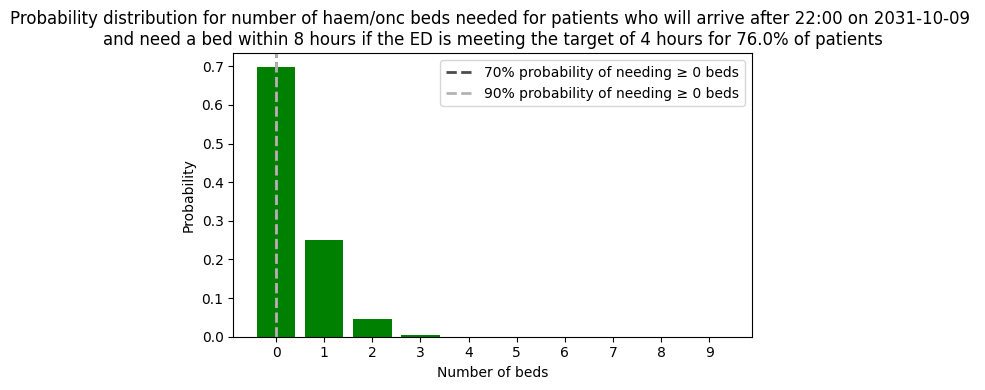

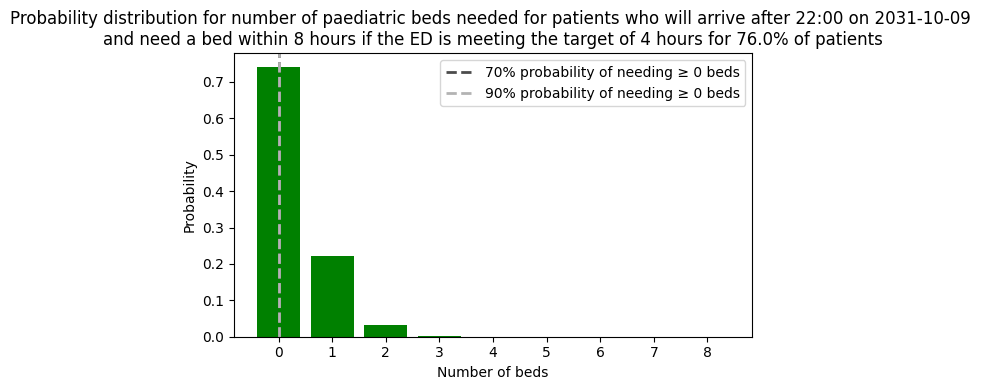

In [58]:
for specialty in [ 'medical', 'surgical', 'haem/onc', 'paediatric']:

    prediction_context = {
        specialty: {
            'prediction_time': random_prediction_time
        }
    }

    weighted_poisson_prediction = yta_model_by_spec.predict(prediction_context, x1=x1, y1=y1, x2=x2, y2=y2)
    title = (
    f'Probability distribution for number of {specialty} beds needed for patients '
    f'who will arrive after {format_prediction_time((random_prediction_time))} on {random_prediction_date} '
    f'\nand need a bed within 8 hours '
    f'if the ED is meeting the target of {int(x1)} hours for {y1*100}% of patients'
)
    plot_prob_dist(weighted_poisson_prediction[specialty], title,  
        include_titles=True,
        truncate_at_beds=20,
        probability_levels=[0.7,0.9],
        show_probability_thresholds=True,
        figsize=(6, 4) , bar_colour='green')

##  Combining the predictions into one function for use in real-time inference

The function shown below is the one used for real-time prediction at UCLH. It returns the probability distributions with the lower threshold set at the requested level using the `cdf_cut_points` argument.

The function returns a dictionary, which is inserted into cells in a spreadsheet (via a process not shown here, as this is not done by the `patientflow` repo) to create the output requested by the users.

In [66]:
from patientflow.predict.emergency_demand import create_predictions

models = (admission_model, spec_model, yta_model_by_spec)

# convert elapsed_los to timedelta to ensure correct calculation of probability of admission within prediction window
prediction_snapshots['elapsed_los'] = pd.to_timedelta(prediction_snapshots['elapsed_los'], unit='s')

create_predictions(
    models = models,
    prediction_time = random_prediction_time,
    prediction_snapshots = prediction_snapshots,
    specialties = ['medical', 'surgical', 'haem/onc', 'paediatric'],
    prediction_window = timedelta(hours=8),
    cdf_cut_points =  [0.7, 0.9], 
    x1 = x1,
    y1 = y1,
    x2 = x2, 
    y2 = y2)

{'medical': {'in_ed': [7, 5], 'yet_to_arrive': [1, 0]},
 'surgical': {'in_ed': [2, 1], 'yet_to_arrive': [0, 0]},
 'haem/onc': {'in_ed': [2, 1], 'yet_to_arrive': [0, 0]},
 'paediatric': {'in_ed': [0, 0], 'yet_to_arrive': [0, 0]}}

## Make predictions using empirical survival curve

If your implementation does not use ED targets, the predictions can be generated using empirical data to calculate the probability that a patient to be admitted within the prediction window. 

First, I show how a survival curve would be used to calculate this probability of admission within the window. Then I re-implement the creation of predictions

In [68]:
## Add synthetic value for admitted_to_ward_datetime to the dataset, if not available

import numpy as np

if 'admitted_to_ward_datetime' not in train_inpatient_arrivals_df.columns:

    scale_hours = 12  # Average length of stay in hours
    length_of_stay_minutes = np.random.exponential(scale=scale_hours * 60, size=len(train_inpatient_arrivals_df))

    # Clip to reasonable bounds (1 hour minimum, 2 days maximum)
    length_of_stay_minutes = np.clip(length_of_stay_minutes, 0, 5 * 24 * 60)

    train_inpatient_arrivals_df['admitted_to_ward_datetime'] = [
        arrival + pd.Timedelta(minutes=los)
        for arrival, los in zip(train_inpatient_arrivals_df.index, length_of_stay_minutes)
    ]



In [ ]:
from patientflow.viz.survival_curve import plot_admission_time_survival_curve
title = 'Survival curve showing probability of still being in the ED after a given elapsed time since arrival'
survival_df = plot_admission_time_survival_curve(train_inpatient_arrivals_df.reset_index(), 
                                   start_time_col="arrival_datetime",
                                   end_time_col="admitted_to_ward_datetime",
                                   title=title,
                                   ylabel='Proportion of patients not yet admitted',
                                   xlabel='Elapsed time since arrival',
                                   target_hours=[4, 8],
                                   annotation_string="{:.1%} of patients admitted\nby {:.0f} hours",
                                   return_df=True,
                                   return_figure=False
)

`patientflow` includes a function to look up the probability of admission within a prediction window, using the survival curve. This is demonstrated below. It is used in the `create_predictions` function if the optional parameter `use_admission_in_window_prob` is set.

In [ ]:
from patientflow.calculate.admission_in_prediction_window import calculate_admission_probability_from_survival_curve

prob_admission_in_window_from_survival_curve = calculate_admission_probability_from_survival_curve(
    elapsed_los = timedelta(hours=1), 
    prediction_window = prediction_window,
    survival_df = survival_df
)

print(f'Probability of admission in prediction window of {prediction_window.total_seconds() / 3600:.0f} hours, assuming patient has been in ED for 1 hour: {prob_admission_in_window_from_survival_curve:.2}')

For an array of patients, the probability of admission within the window would be created as shown below.

In [ ]:
from patientflow.calculate.admission_in_prediction_window import calculate_admission_probability_from_survival_curve

# Calculate probability of admission within prediction window using ED targets
prob_admission_in_window_from_survival_curve = prediction_snapshots.apply(
    lambda row: calculate_admission_probability_from_survival_curve(
        elapsed_los = row["elapsed_los"], 
        prediction_window = prediction_window,
        survival_df = survival_df
    ),
    axis=1,
)


Predictions are created exactly as before. 


In [69]:
from patientflow.predict.emergency_demand import create_predictions
from patientflow.predictors.incoming_admission_predictors import EmpiricalIncomingAdmissionPredictor

# First I'll train the empirical yet-to-arrive model
train_inpatient_arrivals_df_copy = train_inpatient_arrivals_df.copy(deep=True)

num_days = (start_validation_set - start_training_set).days

# the arrival_datetime column needs to be set as the index of the dataframe
if 'arrival_datetime' in train_inpatient_arrivals_df_copy.columns:
    train_inpatient_arrivals_df_copy.set_index('arrival_datetime', inplace=True)

specialty_filters = filters={
    'medical': {'specialty': 'medical'},
    'surgical': {'specialty': 'surgical'},
    'haem/onc': {'specialty': 'haem/onc'},
    'paediatric': {'specialty': 'paediatric'}
    }

yta_model_by_spec_empirical =  EmpiricalIncomingAdmissionPredictor(filters = specialty_filters, verbose=False)
yta_model_by_spec_empirical.fit(train_inpatient_arrivals_df_copy, 
                        prediction_window=prediction_window, 
                        yta_time_interval=yta_time_interval, 
                        prediction_times=ed_visits.prediction_time.unique(), 
                        num_days=num_days,
                        start_time_col='arrival_datetime',
                        end_time_col='admitted_to_ward_datetime')

models = (admission_model, spec_model, yta_model_by_spec_empirical)

# convert elapsed_los to timedelta to ensure correct calculation of probability of admission within prediction window
prediction_snapshots['elapsed_los'] = pd.to_timedelta(prediction_snapshots['elapsed_los'], unit='s')

create_predictions(
    models = models,
    prediction_time = random_prediction_time,
    prediction_snapshots = prediction_snapshots,
    specialties = ['medical', 'surgical', 'haem/onc', 'paediatric'],
    prediction_window = prediction_window,
    cdf_cut_points =  [0.7, 0.9], 
    x1 = x1,
    y1 = y1,
    x2 = x2, 
    y2 = y2,
    use_admission_in_window_prob = True)

{'medical': {'in_ed': [7, 5], 'yet_to_arrive': [0, 0]},
 'surgical': {'in_ed': [2, 1], 'yet_to_arrive': [0, 0]},
 'haem/onc': {'in_ed': [2, 1], 'yet_to_arrive': [0, 0]},
 'paediatric': {'in_ed': [0, 0], 'yet_to_arrive': [0, 0]}}

## Summary

Here I have shown how `patientflow` is used at UCLH to generate predictions of emergency demand for beds in the next 8 hours. There are two elements to the predictions. 

* predictions for patients already in the ED
* predictions for patients yet-to-arrive to the ED, who will need admission in the next 8 hours

Both sets of predictions assume specified ED targets are met. 

I also showed an alternative approach, in which predictions used past data to calculate probability of admission within a prediction window; in this case no assumption is made about ED targets being met.

In the next notebook, I show how to evaluate the predictions against the numbers of patients actually admitted. 